In [1]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/multi_agent_sim")
from multi_agent_sim import MultiAgentSim

In [ ]:

social_network_params_high_var = {
    'location_vec_dim': 2,
    'network_gamma': 3,
    'daily_contacts_distn_type': 'negative_binomial',
    'neg_bin_r': 2,
    'neg_bin_p_hyperparams': (2,3),
}

n_agents = 1000
expected_total_outside_infs = 5
time_horizon = 7 * 12
main_params = {
    'n_agents': n_agents,
    'use_contact_tracing': True,
    'use_adaptive_testing': True,
    'use_surveillance_testing': True
}

infection_dynamics_params = {
    'forward_gen_alpha': 8,
    'forward_gen_beta_hyperparams': (5,5),
    'detectability_curve_type': 'optimistic',
    'self_reporting_multiplier': 0.8,
    'self_reporting_delay': 3,
    'init_infection_rate': 0,
    'use_deterministic_infection_counts': True,
    'disc_gamma_transmission_mult': 1
    'outside_infection_rate': expected_total_outside_infs / (n_agents * time_horizon)
}

ct_params = {
    'ct_recall_window': 8,
    'ct_delay_distribution': [1/3,1/3,1/3], # uniform over 0, 1, 2 days delay
    'ct_recall_rate': 0.5
}

at_params = {
    'at_delay_distribution': [1/5] * 5,
    'at_net_size_contact_multiplier': 10,
    'at_recall_rate': 0.9
}

st_params = {
    'st_testing_window': 3,
    'st_missed_test_rate': 0.1
}

def init_high_var_sim(R0):
    social_network_params_high_var['neg_bin_r'] = R0 / 0.9
    return MultiAgentSim(main_params, infection_dynamics_params, social_network_params_high_var, 
                         ct_params, at_params, st_params)

social_network_params_low_var = {
    'location_vec_dim': 2,
    'network_gamma': 3,
    'daily_contacts_distn_type': 'negative_binomial',
    'neg_bin_r': 2,
    'neg_bin_p_hyperparams': (5,6),
}

#  r * (alpha) / (beta - 1) = 1 = default R0

def init_low_var_sim(R0):
    social_network_params_low_var['disc_gamma_transmission_mult'] = R0 
    return MultiAgentSim(main_params, infection_dynamics_params, social_network_params_low_var, 
                         ct_params, at_params, st_params)

In [3]:
def sample_trajectory(R0, at_multiplier, st_testing_window, 
                      use_adaptive_testing = True, use_surveillance_testing = True):
    st_params['st_testing_window'] = st_testing_window
    at_params['at_net_size_contact_multiplier'] = at_multiplier
    main_params['use_adaptive_testing'] = use_adaptive_testing
    main_params['use_surveillance_testing'] = use_surveillance_testing
    sim = init_low_var_sim(R0)
    infection_counts = [len(sim.infection.get_cum_infected_agent_ids())]
    init_infection_counts = infection_counts[0]
    for _ in range(7*12):
        sim.step()
        infection_counts.append(len(sim.infection.get_cum_infected_agent_ids()))
    total_tests = sim.get_total_tests()
    return total_tests, infection_counts, init_infection_counts, infection_counts[-1]

# Description:
Have (maybe one or two) nominal adaptive testing protocol, and 1-2 nominal surveillance testing protocol, and 1-2 nominal contact trace only protocols, and simulate all of them over multiple R0 values, & record total infections as well as total test usage

sample_trajectory (defined above) lets us sample a single trajectory for a particular value of at_multiplier, of st_testing_window

In [ ]:
R0s_to_try = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

adaptive_test_policies = [(8, 4, True, True), 
                          #(8, 7, True, True), (12, 4, True, True), 
                          (12, 7, True, True)]
no_use = 1
surveillance_test_policies = [(no_use, 4, False, True), (no_use, 7, False, True)]
contact_trace_policy = [(no_use, no_use, False, False)]

all_policies = adaptive_test_policies + surveillance_test_policies + contact_trace_policy

ntrajectories = 25

sim_results = {}

from datetime import datetime

for R0 in R0s_to_try:
    print("on R0 {}\n".format(R0))
    for policy in all_policies:
        at_mult, st_window, use_at, use_st = policy
        print("on policy {}\n".format(policy))
        print("Timestamp: {}\n".format(datetime.now()))
        sim_results[(R0, policy)] = [sample_trajectory(R0, at_mult, st_window, use_at, use_st) for _ in range(ntrajectories)]


on R0 1



In [5]:
len(sim_results)

25

# Plot average infections

In [8]:
sim_results[(3, (1,1,False,False))][0]

(0,
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  2,
  2,
  3,
  3,
  5,
  5,
  6,
  7,
  9,
  9,
  13,
  16,
  23,
  25,
  27,
  31,
  35,
  41,
  45,
  48,
  54,
  59,
  63,
  67,
  72,
  74,
  77,
  78,
  81,
  86,
  92,
  95,
  99,
  101,
  107,
  111,
  116,
  122,
  133,
  140,
  147,
  154,
  159,
  161,
  162,
  165,
  167,
  170,
  170,
  174,
  176,
  178,
  178,
  182,
  184,
  186,
  188,
  193,
  206,
  212,
  213,
  214,
  216,
  222,
  223,
  228,
  229,
  230,
  232],
 0,
 232)

In [5]:
avg_infxns_by_policy = {policy:[] for policy in all_policies}

for policy in all_policies:
    for R0 in R0s_to_try:
        avg_infxns = np.mean([r[-1] for r in sim_results[(R0, policy)]])
        avg_infxns_by_policy[policy].append(avg_infxns)

In [6]:
all_policies

[(8, 4, True, True),
 (12, 7, True, True),
 (1, 4, False, True),
 (1, 7, False, True),
 (1, 1, False, False)]

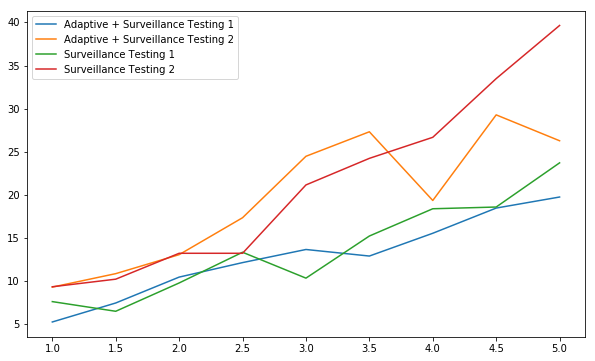

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

policy_names = {
    (8,4,True,True): "Adaptive + Surveillance Testing 1",
    (12,7,True,True): "Adaptive + Surveillance Testing 2",
    (1,4, False, True): "Surveillance Testing 1",
    (1,7,False, True): "Surveillance Testing 2",
    (1,1,False,False): "Contact Tracing Only"
}

plt.figure(figsize=(10,6))

for policy in all_policies:
    if policy == (1,1,False,False):
        continue
    plt.plot(R0s_to_try, avg_infxns_by_policy[policy], label=policy_names[policy])

plt.legend(loc='best')
plt.show()

# Plot test usage

In [9]:
avg_test_usage_by_policy = {policy:[] for policy in all_policies}

for policy in all_policies:
    for R0 in R0s_to_try:
        avg_tests = np.mean([r[0] for r in sim_results[(R0, policy)]])
        avg_test_usage_by_policy[policy].append(avg_tests)

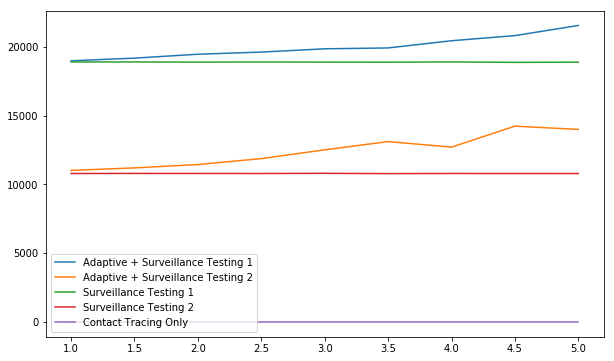

In [10]:
plt.figure(figsize=(10,6))

for policy in all_policies:
    plt.plot(R0s_to_try, avg_test_usage_by_policy[policy], label=policy_names[policy])

plt.legend(loc='best')
plt.show()